Задание:
Импортировать данные с помощью pandas 
Проверить данные на корректность типов и выкинуть признаки, не имеющие отношения к таргету (например, айди пассажира)
Заполнить пропуски по логике: (Ксли пропусков больше 30% - выкинуть, а если нет, то: заполняем либо затычкой(типа -999), либо медианным значением)
Проверить данные на дубликаты (подсказка: методы duplicated() и drop_duplicates())

Провести исследователький анализ данных: 
- вывести графики зависимости каждого признака от таргета (scatter plot)
- вывести распредление данных в разрезе таргета(атрибут hue в матплотлибе), чтобы просто оценить, например, кого выжило больше, мужчин или женщин (для этого всего поможет график barplot)
- проверить данные на аномалии (график boxplot) и ограничить признак, если надо (метод clip)

Провести корреляционный аналоиз данных:
вывести матрицу корреляции всех признаков 

Провести обучение линейных моделей и проверить их по метрикам accuracy, recall, precision, roc-auc, вывести feature_importance и сделать выводы. 
Попробовать визуализировать твою прямую, которая получилась, чтобы как-то интерперетировать результат для заказчика.

# Импорт данных и первоначальный осмотр

In [26]:
import numpy as np
import pandas as pd

dt = pd.read_csv("data/titanic.csv") 
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [27]:
dt.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [28]:
dt.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Проверка типов:
все хорошо, категориальные потом нужно перекодировать (sex, embarked)

In [29]:
for col in dt.columns:
    dup_count = dt[col].duplicated().sum()
    if dup_count > 0:
        print(f"{col} has {dup_count} duplicates")

Survived has 889 duplicates
Pclass has 888 duplicates
Sex has 889 duplicates
Age has 802 duplicates
SibSp has 884 duplicates
Parch has 884 duplicates
Ticket has 210 duplicates
Fare has 643 duplicates
Cabin has 743 duplicates
Embarked has 887 duplicates


Полный дубликатов строк нет, что могло бы говорить о проблеме с данными. Дубликаты по отдельным признакам - нормально

# data preparation

### 1) Обработка пропусков (больше 30% отбрасываем)

In [30]:
treshold = 0.3
to_drop = list(dt.columns[dt.isna().mean() > treshold]) + ["PassengerId", "Name", "Ticket"]
dt1 = dt.drop(to_drop, axis = 1)

### 2) Заполняем медианным значением, если числовые данные. Если не числовые - затычкой.

In [31]:
for column in dt1.columns:
    if dt1[column].isnull().sum() > 0:
        if dt1[column].dtype in ("int64","float64"):
            dt1.fillna(dt1[column].median(), inplace=True)
        else:
            dt1.fillna("Missing", inplace=True)

### 3) One-Hot Encoding для категориальных признаков. Исползуем drop='frist', чтобы избежать мультиколлинеарности

In [32]:
dt1 = pd.get_dummies(dt1, columns=["Sex", "Embarked"], drop_first=True, )

т.к. признак Embarked остался с тремя столбцами, при обучении просто не будем использовать первый из них, чтобы признаки не были линейно зависимы между собой

# Исследовательский анализ данных

Для начала построим графики зависимости выживаемости от признаков, чтобы посмотреть, прослеживаются ли линейные зависимости

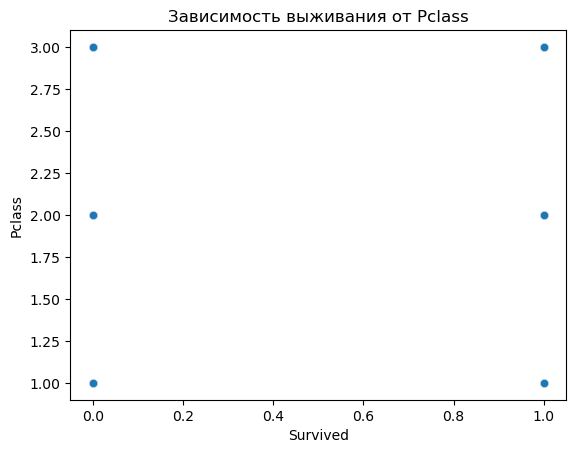

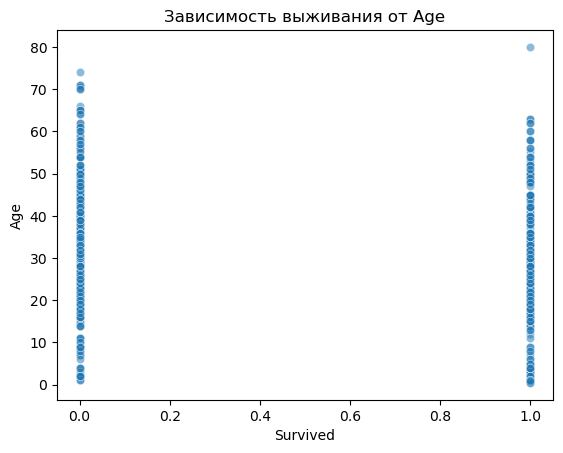

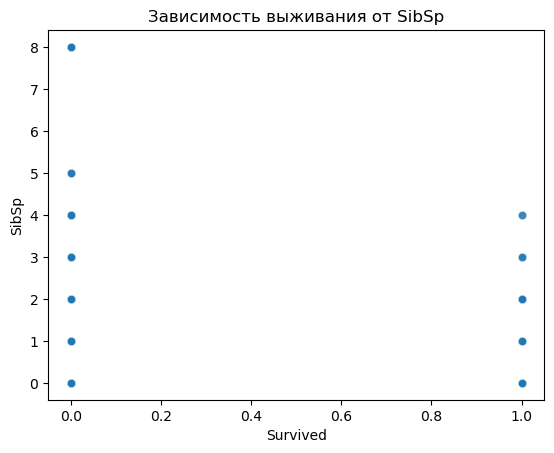

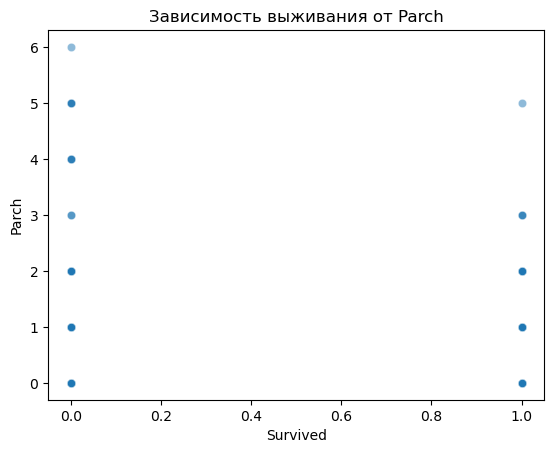

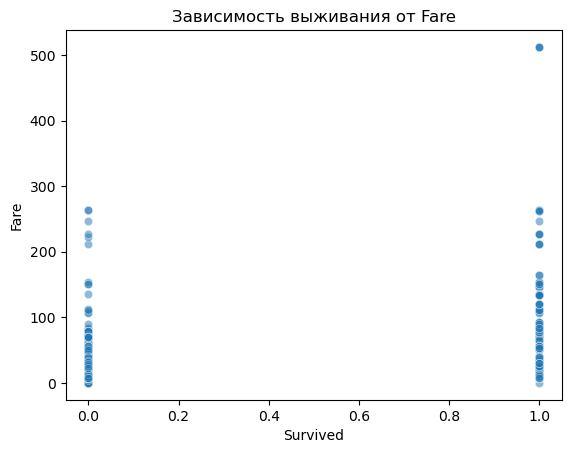

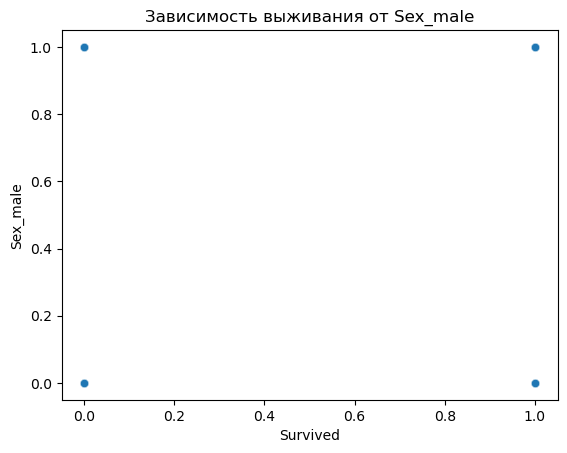

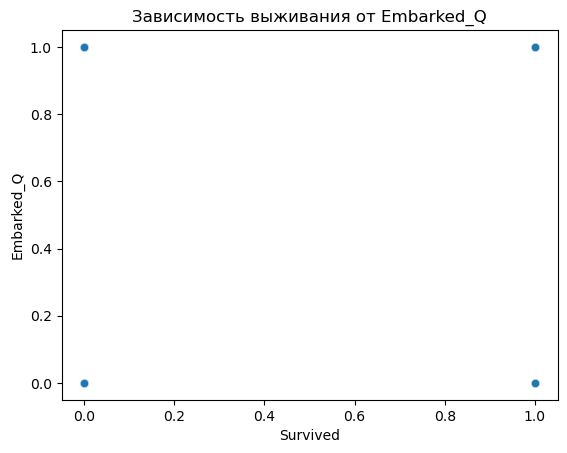

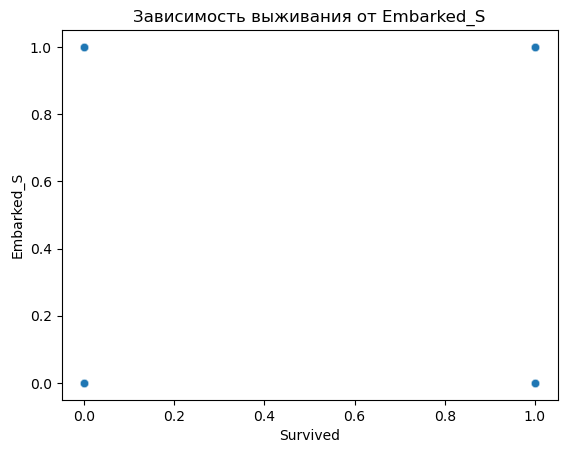

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']
for col in features:
    sns.scatterplot(dt1, x = "Survived",  y = col, alpha=0.5)
    plt.title(f"Зависимость выживания от {col}")
    plt.show()

Таргет в данном датасете категориальный: выжил/не выжил, поэтому в связке с категориальными признаками трудно что-то сказать.
С числовыми признаками также тяжело вычленить зависиммость из графиков, пожалуй можно только сказать, что при большом возрасте вероятность выжить меньше.

Далее построим графики распределения таргета по признакам. Информативность будет только для явно категориальных признаков признаков

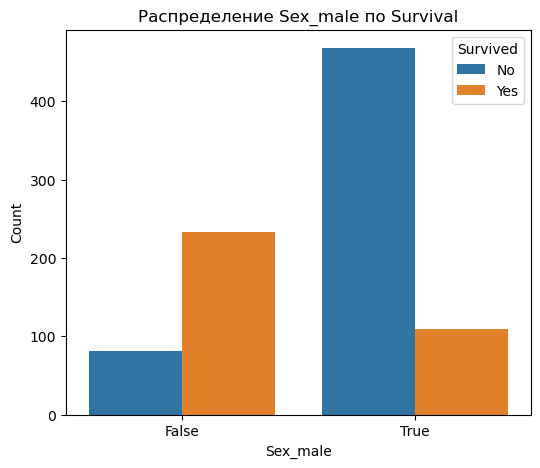

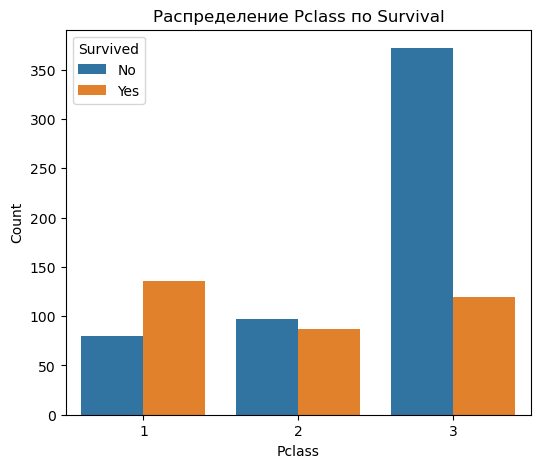

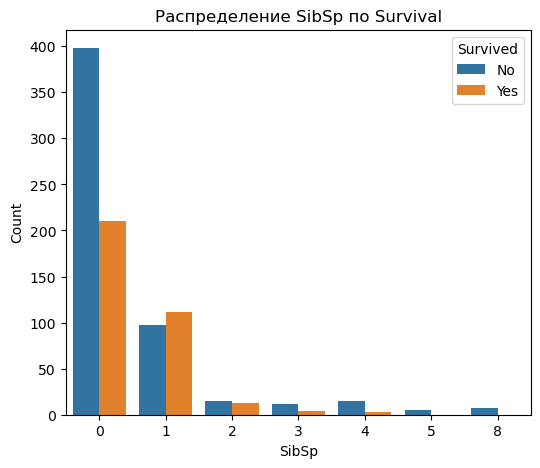

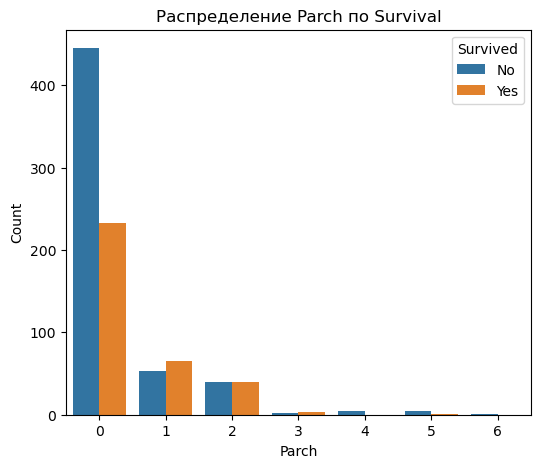

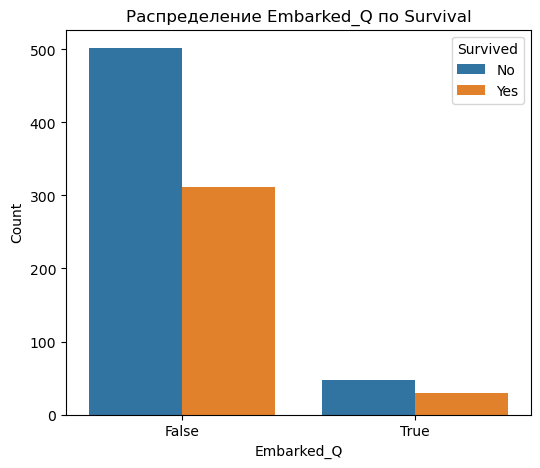

In [34]:
categorical_features = ["Sex_male", "Pclass", 'SibSp', 'Parch', 'Embarked_Q'] 

for feature in categorical_features:
    plt.figure(figsize=(6,5))
    sns.countplot(data=dt1, x=feature, hue="Survived")
    plt.title(f"Распределение {feature} по Survival")
    plt.ylabel("Count")
    plt.xlabel(feature)
    plt.legend(title="Survived", labels=["No", "Yes"])
    plt.show()

Для countplot возьмем только категориальные признаки, тут все уже видно лучше.
Можно сказать, что мужчины выживают чаще женщин, а пассажиры с билетами третьего класса чаще не выживают, что логично.



Построим barplot для данных, а также ограничим выбросы с помощью функции clip().
Эти графики будет целесообразно применять только в отношении числовых признаков, поэтому выделим среди признаков цену билета и возраст

Age


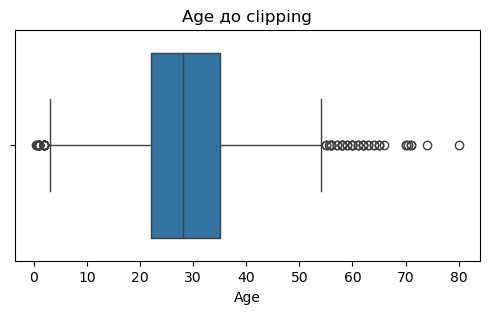

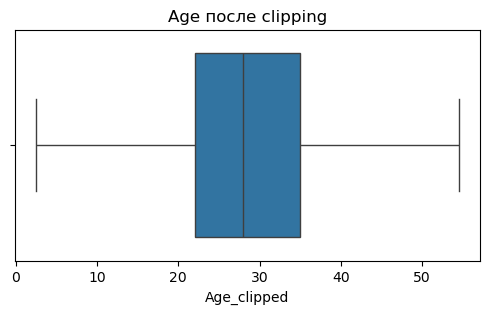

Fare


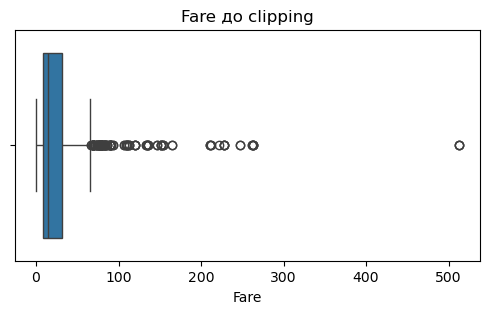

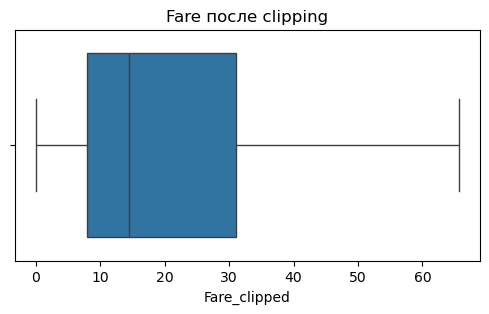

In [35]:
numeric_features = ["Age", "Fare"]

for feature in numeric_features:
    print(f"{feature}")
    
    plt.figure(figsize=(6,3))
    sns.boxplot(x=dt1[feature])
    plt.title(f"{feature} до clipping")
    plt.show()
    
    Q1 = dt1[feature].quantile(0.25)
    Q3 = dt1[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    dt1[feature + "_clipped"] = dt1[feature].clip(lower=lower_limit, upper=upper_limit)
    
    plt.figure(figsize=(6,3))
    sns.boxplot(x=dt1[feature + "_clipped"])
    plt.title(f"{feature} после clipping")
    plt.show()

Мы ограничили признаки по квантилям, графики теперь выглядят лучше, без выбросов.

### Вопрос: выбросы ли в данном случае большой возраст и цена билета, возможно стоит их оставить


Для построения матриц корреляций можно использовать только непрерывные числовые признаки, возьмем класс билета пассажира (чем больше, тем "хуже" условия), возраст, количество людей в семье на борту, цена билета.  

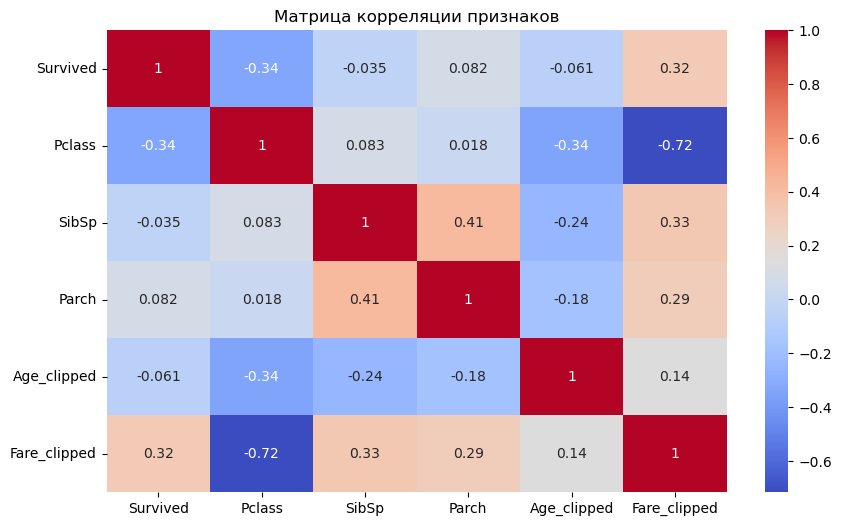

In [36]:
numeric_dt1 = dt1.select_dtypes(include=["int64", "float64"]).drop(["Age", "Fare"], axis = 1)

corr_matrix = numeric_dt1.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Матрица корреляции признаков")
plt.show()

Из матрицы корелляций можно сделать следующие выводы:
чем больше класс билета, тем меньше шансы выжить;
наличие братьев/сестер пагубно сказывается на выживании, хоть и мало влияет,
а вот наличие родителей на борту немного, но увеличивает шансы выжить;
возрастные пассажиры имеют меньшие шансы выжить;
чем больше стоит билет, тем больше шансов выжить.

In [37]:
y = dt1['Survived']
X = dt1[['Pclass', 'Age_clipped', 'SibSp', 'Parch', 'Fare_clipped', 'Sex_male', 'Embarked_Q', 'Embarked_S']]

Разделим данные на тренировочные и проверочные

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Также для того, чтобы модель быстрее сошлась, отмасштабируем признаки

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим логистическую регрессию

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

Метрики для проверки лог. регресси

Accuracy: 0.8097014925373134
Precision: 0.8
Recall: 0.7207207207207207
ROC-AUC: 0.8812187984162506

Confusion matrix:
 [[137  20]
 [ 31  80]]

Feature importance:
         Feature  Coefficient
4  Fare_clipped     0.240131
6    Embarked_Q    -0.049862
3         Parch    -0.104296
7    Embarked_S    -0.247958
2         SibSp    -0.392459
1   Age_clipped    -0.442373
0        Pclass    -0.663189
5      Sex_male    -1.224165


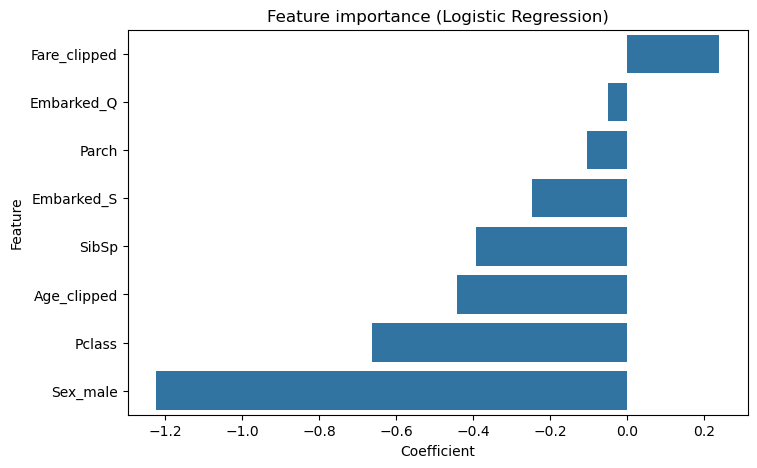

In [41]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.inspection import permutation_importance


y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]

#Осн. метрики
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

#Коэф-ты модели по признакам
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature importance:\n", feature_importance)

#График коэф-в модели для наглядност
plt.figure(figsize=(8,5))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance)
plt.title("Feature importance (Logistic Regression)")
plt.show()

хуита

Построим кривую для логистической регрессии.
Использовать кривую следует только в случае числовых признаков, поэтому построим ее для fare и age 

probs min/max: 0.1373276554671933 0.6939398361229696


C:\Users\toni1\AppData\Local\Temp\ipykernel_19560\164507471.py:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2, label='Граница p=0.5')


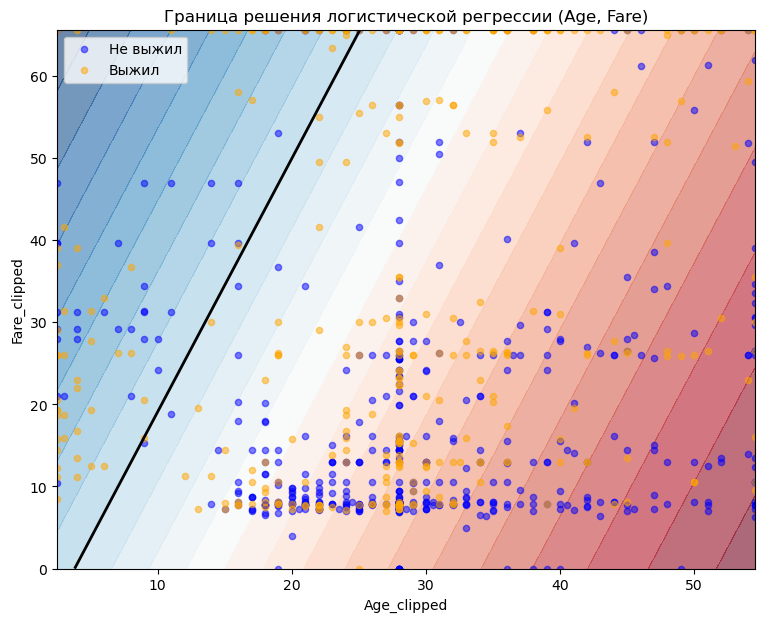

In [42]:
import matplotlib.pyplot as plt


# 1. Список признаков 
# порядок должен быть таким же, как в данных, на которых обучалась модель
features = ['Pclass', 'Age_clipped', 'SibSp', 'Parch',
            'Fare_clipped', 'Sex_male', 'Embarked_Q', 'Embarked_S']

# 2. Диапазоны по Age и Fare
age_min, age_max = X['Age_clipped'].min(), X['Age_clipped'].max()
fare_min, fare_max = X['Fare_clipped'].min(), X['Fare_clipped'].max()

xx, yy = np.meshgrid(
    np.linspace(age_min, age_max, 200),
    np.linspace(fare_min, fare_max, 200)
)

# 3. Создаём DataFrame с типичными значениями
base = X.mean().to_dict()  # медианы
X_grid = pd.DataFrame([base] * (xx.size), columns=features)

# подставляем оси
X_grid['Age_clipped'] = xx.ravel()
X_grid['Fare_clipped'] = yy.ravel()

# 4. Масштабируем, как при обучении
X_grid_scaled = scaler.transform(X_grid)

# 5. Предсказываем вероятность выживания
probs = model.predict_proba(X_grid_scaled)[:, 1].reshape(xx.shape)

print('probs min/max:', probs.min(), probs.max())


# 6. Визуализация
plt.figure(figsize=(9,7))
plt.contourf(xx, yy, probs, levels=25, cmap='RdBu', alpha=0.6)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2, label='Граница p=0.5')

plt.scatter(X['Age_clipped'][y==0], X['Fare_clipped'][y==0],
            s=20, c='blue', alpha=0.5, label='Не выжил')
plt.scatter(X['Age_clipped'][y==1], X['Fare_clipped'][y==1],
            s=20, c='orange', alpha=0.5, label='Выжил')

plt.xlabel('Age_clipped')
plt.ylabel('Fare_clipped')
plt.title('Граница решения логистической регрессии (Age, Fare)')
plt.legend()
plt.show()



In [43]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()
model_lin.fit(X_train_scaled, y_train)

LinearRegression()

Метрики для проверки лин. регрессии

In [44]:
y_pred_lin = model_lin.predict(X_test_scaled)

y_pred_lin_class = (y_pred_lin > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_lin_class))
print(confusion_matrix(y_test, y_pred_lin_class))
print(classification_report(y_test, y_pred_lin_class))

Accuracy: 0.7910447761194029
[[133  24]
 [ 32  79]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       157
           1       0.77      0.71      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



In [45]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lin.coef_[0]
})
print(coefficients)

        Feature  Coefficient
0        Pclass    -0.108501
1   Age_clipped    -0.108501
2         SibSp    -0.108501
3         Parch    -0.108501
4  Fare_clipped    -0.108501
5      Sex_male    -0.108501
6    Embarked_Q    -0.108501
7    Embarked_S    -0.108501
